In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aging.behavior.syllables import relabel_by_usage
import colorcet as cc
from pathlib import Path
import math

In [2]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 12
    if '6m' in string:
        return 24
    if '9m' in string:
        return 36
    if '12m' in string:
        return 52
    if '18m' in string:
        return 78
    if '22m' in string:
        return 90
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

## upload data and housekeeping

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_syllable_df_v00.parquet')

In [4]:
# relabel syllables by usage and add age
df = relabel_by_usage(df, return_map=False)
df['age'] = df['age'].map(age_map)
# map CRL mice as 91 age to make them different
df.loc[df['session_name'] == 'ontogeny_males_22months_CRL', 'age'] = int(91)

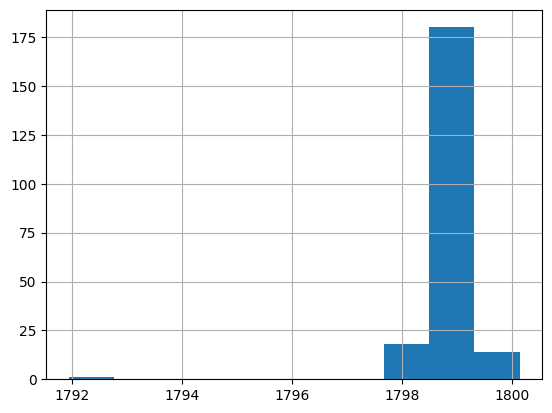

In [5]:
# clean up the data by removing short sessions
t = 600
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < t].index
session_length.hist()
df = df[~df['uuid'].isin(remove_uuids)]

In [6]:
# compute usge

In [7]:
usage_df = df.query('onsets').groupby(['age', 'subject_name', 'session_name','uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()
usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','subject_name','session_name', 'uuid']).fillna(0)

In [8]:
from collections import Counter
Counter(usage_mtx.index.get_level_values(0))

Counter({12: 27,
         78: 27,
         52: 26,
         24: 24,
         3: 16,
         5: 16,
         36: 16,
         90: 16,
         91: 16,
         7: 15,
         9: 14})

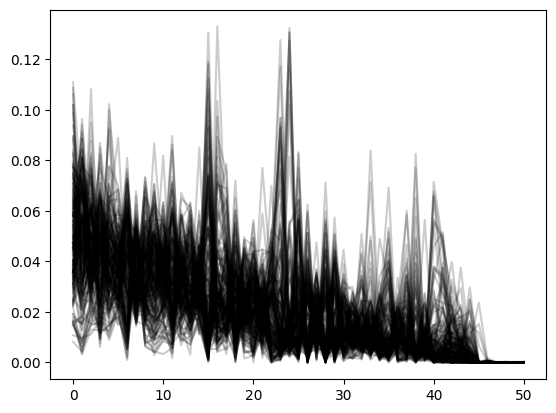

In [9]:
# remove sessions with abnormally high syllable usage
us = 0.2
usage_mtx = usage_mtx[~(usage_mtx > us).any(axis=1)]
plt.plot(usage_mtx.values.T, c='k', alpha=0.2);

In [10]:
sorted(usage_mtx.index.get_level_values(1).unique())

['c01_m01_b01',
 'c01_m02_b02',
 'c01_m03_b03',
 'c01_m04_b04',
 'c02_m01_b01',
 'c02_m02_b02',
 'c02_m03_b03',
 'c02_m04_b04',
 'c03_m01_b01',
 'c03_m02_b02',
 'c03_m03_b03',
 'c03_m04_b04',
 'c04_m01_b01',
 'c04_m02_b02',
 'c04_m03_b03',
 'c04_m04_b04',
 'c07_m01_b01',
 'c07_m02_b02',
 'c07_m03_b03',
 'c07_m04_b04',
 'c08_m01_b01',
 'c08_m01_b04',
 'c08_m02_b02',
 'c08_m02_b04',
 'c08_m03_b03',
 'm012_c03_b04_s01',
 'm016_c04_b04_s01',
 'm01_b01_c01',
 'm01_c01_b01_s01',
 'm01b01c01',
 'm02_b02_c01',
 'm02_c01_b02_s01',
 'm02b02c01',
 'm03_c01_b03_s01',
 'm03b03c01',
 'm04_b04_c01',
 'm04_c01_b04_s01',
 'm04_c04_b04_s01',
 'm04b04c01',
 'm05_c01_b01_s01',
 'm05_c02_b01_s01',
 'm05b01c02',
 'm06_c02_b02_s01',
 'm06b02c02',
 'm07_c02_b03_s01',
 'm07b03c02',
 'm08_c02_b04_s01',
 'm08b04c02',
 'm09_c03_b01_s01',
 'm09b01c03',
 'm10_c03_b02_s01',
 'm10b02c03',
 'm11_c03_b03_s01',
 'm11b03c03',
 'm12_c03_b04_s01',
 'm12b04c03',
 'm13_b01_c01',
 'm13_c04_b01_s01',
 'm13b01c01',
 'm14_b02_c0

In [11]:
from collections import Counter
Counter(usage_mtx.index.get_level_values(0))

Counter({12: 27,
         78: 27,
         52: 26,
         24: 24,
         3: 16,
         5: 16,
         36: 16,
         90: 16,
         91: 16,
         7: 15,
         9: 14})

In [12]:
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05')
usage_mtx.to_parquet(data_folder / "ontogeny_males_clean_v1.parquet", engine='pyarrow') 

In [13]:
#get random 16 mice for ages in which there are more than 16 mice
n=16
usage_mtx = usage_mtx.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)

In [14]:
Counter(usage_mtx.index.get_level_values(0))

Counter({3: 16,
         5: 16,
         12: 16,
         24: 16,
         36: 16,
         52: 16,
         78: 16,
         90: 16,
         91: 16,
         7: 15,
         9: 14})

In [15]:
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05')
usage_mtx.to_parquet(data_folder / "ontogeny_males_clean_v2.parquet", engine='pyarrow') 